# Gravitational orbit in Cartesian coordinates

Defines an Orbit class that is used to generate basic trajectory plots for two bodies by solving Lagrange's equations.

Created by Yuqi Wang (wang.8615@osu.edu).

## Euler-Lagrange equation

For two bodies, the Lagrangian with generalized coordinate $x_1$, $x_2$, $y_1$, $y_2$ are

$\begin{align}
  \mathcal{L} = T-U = \frac12 m_1 (\dot x_1^2+\dot y_2^2)+\frac12 m_2 (\dot x_2^2+\dot y_2^2)+\frac {G m_1 m_2} {\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}}
\end{align}$

The Euler-Lagrange equation are

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_1} = \frac{\partial\mathcal L}{\partial x_1}
 \quad\Longrightarrow\quad
 m_1 \ddot x_1 = \frac {-G m_1 m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_2} = \frac{\partial\mathcal L}{\partial x_2}
 \quad\Longrightarrow\quad
 m_2 \ddot x_2 = \frac { G m_1 m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_1} = \frac{\partial\mathcal L}{\partial y_1}
 \quad\Longrightarrow\quad
 m_1 \ddot y_1 = \frac {-G m_1 m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_2} = \frac{\partial\mathcal L}{\partial y_2}
 \quad\Longrightarrow\quad
 m_2 \ddot y_2 = \frac { G m_1 m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}
 \;
\end{align}$

Finally solve for $\ddot x_1$, $\ddot x_2$, $\ddot y_1$, $\ddot y_2$

$\begin{align}
 \ddot x_1 = \frac {-G m_2 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot x_2 = \frac { G m_1 (x_1-x_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot y_1 = \frac {-G m_2 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}\\
 \;
 \ddot y_2 = \frac { G m_1 (y_1-y_2)} {(\sqrt{(x_1-x_2)^2+(y_1-y_2)^2})^3}
 \;
\end{align}$


In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Orbit class and utility functions

In [4]:
class Orbit():
    """
    Pendulum class implements the parameters and Lagranges's equations for 
     double pendulum (no driving or damping).
     
    Parameters
    ----------
    G : float
        Universal gravitational constant
    mass1 : float
        mass of the first body
    mass2 : float
        mass of the second body

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    
    def __init__(self, mass1=1.,mass2=1., G=1. 
                ):
        self.G = G
        self.mass1 = mass1
        self.mass2 = mass2

    def dy_dt(self, t, y):
        
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dx2/dt d^2x2/dt^2 dy1/dt d^2y1/dt^2 dy2/dt d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 8-component vector with 
            y[0] = x1(t) and y[1] = dx1/dt
            y[2] = x2(t) and y[3] = dx2/dt
            y[4] = y1(t) and y[5] = dy1/dt
            y[6] = y2(t) and y[7] = dy2/dt         
        Returns
        -------
        
        """
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = y
        cmultiplier = self.G*self.mass1*self.mass2*((x1-x2)**2+(y1-y2)**2)**(-3/2)
        x1_double_dot = -cmultiplier*(x1-x2)/self.mass1
        x2_double_dot = cmultiplier*(x1-x2)/self.mass2
        y1_double_dot = -cmultiplier*(y1-y2)/self.mass1
        y2_double_dot = cmultiplier*(y1-y2)/self.mass2
        
        return x1_dot, x1_double_dot, x2_dot, x2_double_dot, y1_dot, y1_double_dot, y2_dot, y2_double_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = solution.y

        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot

    def solve_ode_Leapfrog(self, t_pts, x1_0, x1_dot_0, x2_0, x2_dot_0, y1_0, y1_dot_0, y2_0, y2_dot_0,):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], x2[i], x2_dot[i], y1[i], y1_dot[i], y2[i], y2_dot[i]]
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = x2[i] + y2_dot_half[i] * delta_t
            
            
            y = [x1[i+1], x1_dot[i], x2[i+1], x2_dot[i], y1[i+1], y1_dot[i], y2[i+1], y2_dot[i]]
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.           
           
        return x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot
        
    
    def energy(self, x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot):
        distance = np.sqrt((x1-x2)**2+(y1-y2)**2)
        KE = 0.5*self.mass1*(x1_dot**2+y1_dot**2)+0.5*self.mass2*(x2_dot**2+y2_dot**2)
        PE = -self.G*self.mass1*self.mass2/distance
        return KE + PE

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Part (a) : Make trajectory plots

In [33]:
# Labels for individual plot axes
trajectory_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

G = 2.5
mass1 = 1.
mass2 = 1.

# Instantiate two body
o1 = Orbit(mass1=mass1, mass2=mass2, G=G)

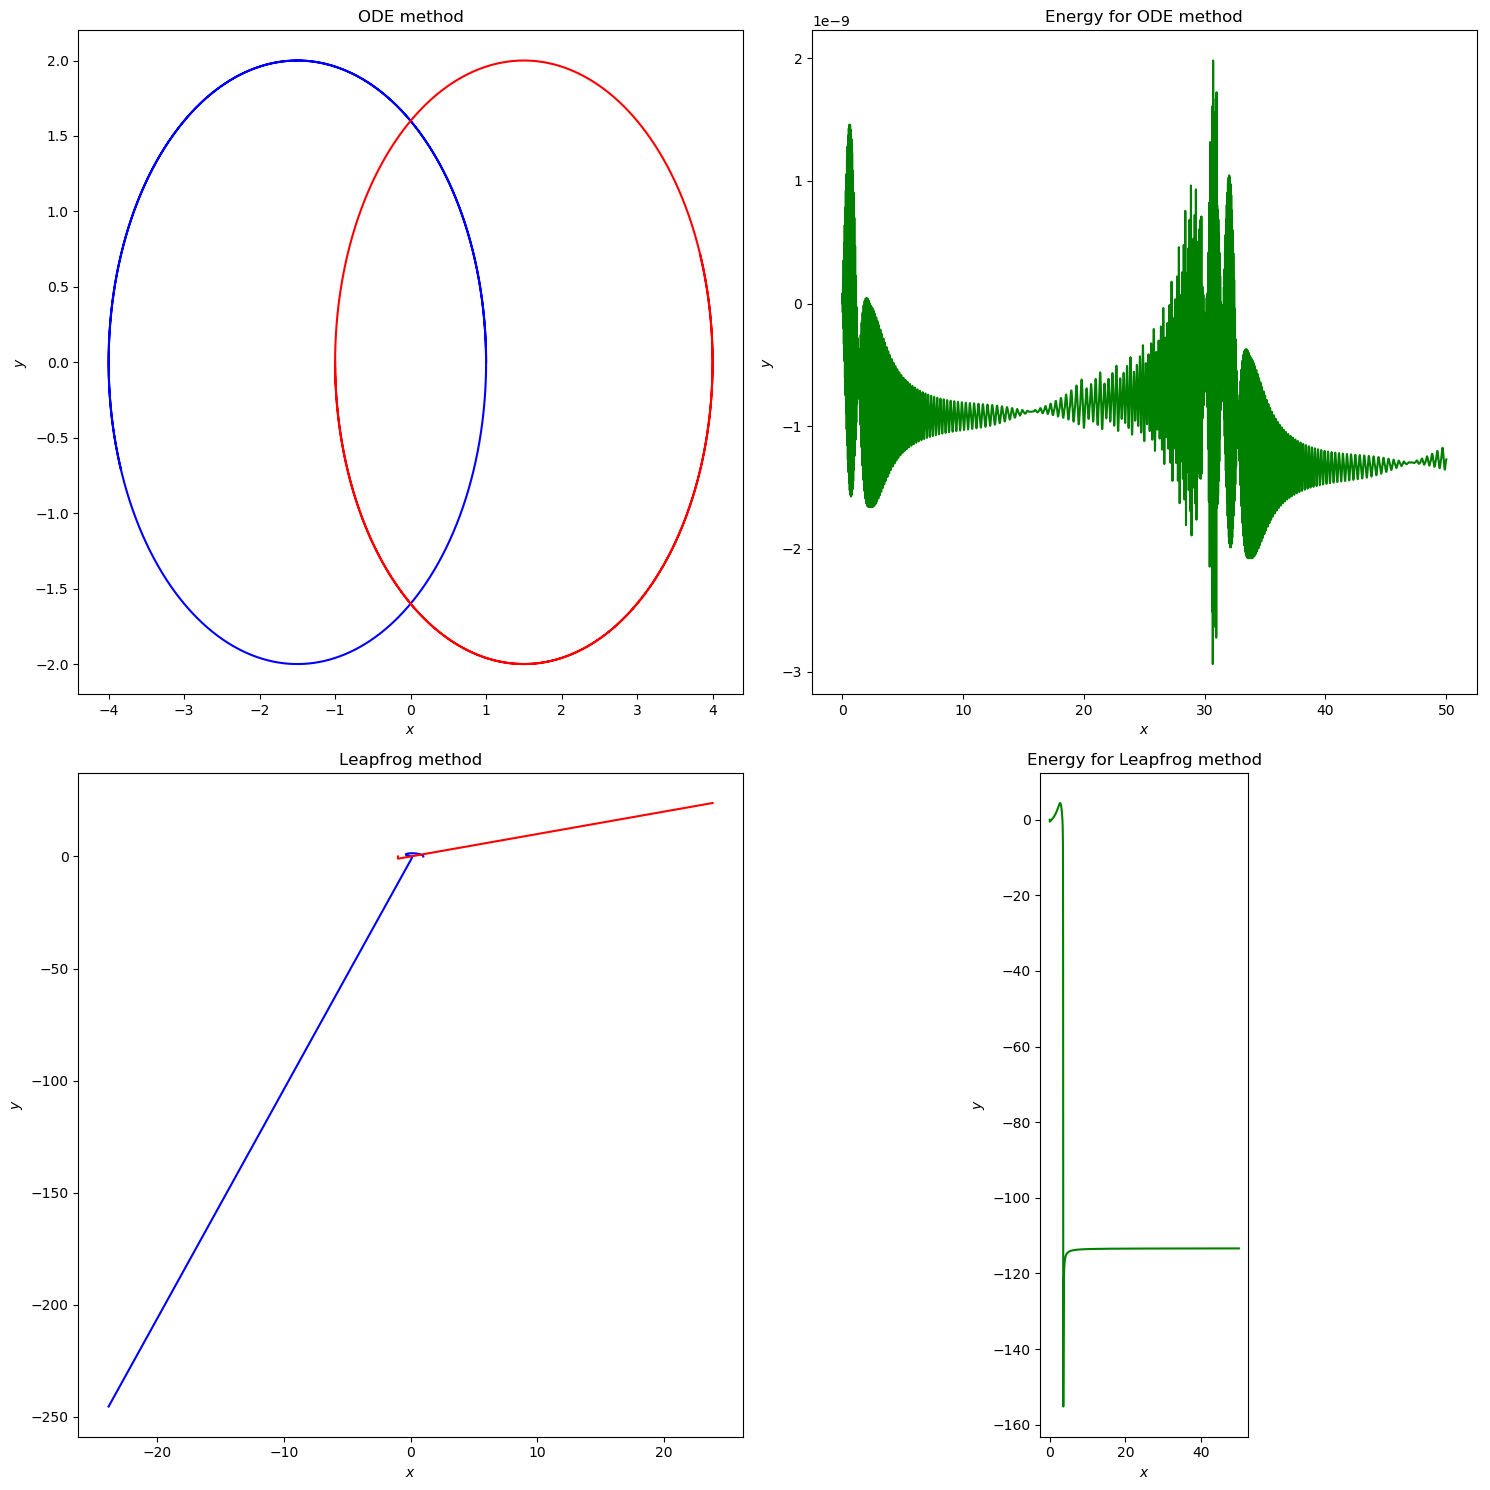

In [43]:
x1_0 = 1
x1_dot_0 = 0
x2_0 = -1
x2_dot_0 = 0
y1_0 = 0
y1_dot_0 = 1
y2_0 = 0
y2_dot_0 = -1

x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot = o1.solve_ode(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0)

x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF = o1.solve_ode_Leapfrog(t_pts, \
                                                              x1_0, x1_dot_0, x2_0, x2_dot_0, \
                                                              y1_0, y1_dot_0, y2_0, y2_dot_0)
#ENERGY
energy=o1.energy(x1, x1_dot, x2, x2_dot, y1, y1_dot, y2, y2_dot)
energy_initial=energy[0]
relative_energy_difference=(energy-energy_initial)/energy_initial

energy_LF=o1.energy(x1_LF, x1_dot_LF, x2_LF, x2_dot_LF, y1_LF, y1_dot_LF, y2_LF, y2_dot_LF)
energy_initial_LF=energy_LF[0]
relative_energy_difference_LF=(energy_LF-energy_initial_LF)/energy_initial_LF

# start the plot!

fig = plt.figure(figsize=(15,15))
"""
overall_title = 'Orbit in Cartesian coordinate:  ' + \
                rf' $x1_0 = {x1_0:.2f},$' + \
                rf' $\dot x1_0 = {x1_dot_0:.2f},$' + \
                rf' $x2_0 = {x2_0:.2f},$' + \
                rf' $\dot x2_0 = {x2_dot_0:.2f},$' + \
                '\n'     #\n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
"""
# trajectory plot 
ax_a = fig.add_subplot(2,2,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label=None, 
            title='ODE method', 
            ax=ax_a)  

plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label=None,
            ax=ax_a)  

ax_a = fig.add_subplot(2,2,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], relative_energy_difference[start : stop], 
            axis_labels=trajectory_labels, 
            color='green',
            label=None, 
            title='Energy for ODE method', 
            ax=ax_a)  


ax_a = fig.add_subplot(2,2,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_LF[start : stop], y1_LF[start : stop], 
            axis_labels=trajectory_labels, 
            color='blue',
            label=None, 
            title='Leapfrog method', 
            ax=ax_a)  

plot_y_vs_x(x2_LF[start : stop], y2_LF[start : stop], 
            axis_labels=trajectory_labels,
            color='red',
            label=None,
            ax=ax_a)  

ax_a = fig.add_subplot(2,2,4)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], relative_energy_difference_LF[start : stop], 
            axis_labels=trajectory_labels, 
            color='green',
            label=None, 
            title='Energy for Leapfrog method', 
            ax=ax_a)  



ax_a.set_aspect(1)
fig.tight_layout()
fig.savefig('orbit_LF.pdf', bbox_inches='tight')  